In [1]:
#Set up and Read the data
import pandas as pd
import sqlite3

# read csv file
df_Fact = pd.read_csv('data.csv')

In [2]:
df_Fact

,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/09/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/09/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/09/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/09/2011 12:50,4.15,12680.0,France


In [3]:
# connect to database
conn = sqlite3.connect("RFMdb")
cur = conn.cursor()

In [4]:
# load CRM data into the RFMdb database
df_Fact.to_sql("data", conn, if_exists="replace")

541909

In [7]:
# CHECK IF DATA INSERTED INTO data/RFMdb
df_Fact = pd.read_sql('SELECT * FROM data', conn)
df_Fact

,index,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/09/2011 12:50,0.85,12680.0,France
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/09/2011 12:50,2.10,12680.0,France
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/09/2011 12:50,4.15,12680.0,France
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/09/2011 12:50,4.15,12680.0,France


In [6]:

cleandata= pd.read_sql(''' SELECT customerid,
                   MAX(receiptdate) AS last_order_date,
                   COUNT(*) AS count_order,
                   SUM(unitprice*quantity) AS totalprice
                   FROM data
                   WHERE receiptno NOT LIKE '%C%'
                   AND customerid IS NOT NULL
                   AND unitprice != 0
                   GROUP BY customerid ''', conn)

In [7]:
cleandata

,CustomerID,last_order_date,count_order,totalprice
0,12346.0,1/18/2011 10:01,1,77183.60
1,12347.0,12/07/2011 15:52,182,4310.00
2,12348.0,9/25/2011 13:13,31,1797.24
3,12349.0,11/21/2011 9:51,73,1757.55
4,12350.0,02/02/2011 16:01,17,334.40
...,...,...,...,...
4333,18280.0,03/07/2011 09:52,10,180.60
4334,18281.0,06/12/2011 10:53,7,80.82
4335,18282.0,12/02/2011 11:43,12,178.05
4336,18283.0,7/14/2011 13:20,756,2094.88


In [8]:
# Write clean CRM data into the database
cleandata.to_sql("cleandata", conn)

4338

In [9]:
#clean the data and calculate rfm values
df_Fact = pd.read_sql(''' SELECT customerid, rfm_recency, rfm_frequency,
rfm_monetary, rfm_recency*100 + rfm_frequency*10 + rfm_monetary AS rfm_combined
    FROM
     ( SELECT customerid,
             NTILE(4) OVER (ORDER BY last_order_date) AS rfm_recency,
             NTILE(4) OVER (ORDER BY count_order) AS rfm_frequency,
             NTILE(4) OVER (ORDER BY totalprice) AS rfm_monetary
      FROM
            cleandata
            )
 ''', conn)



In [10]:
df_Fact

,customerid,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined
0,16282.0,1,1,1,111
1,15266.0,1,1,1,111
2,15464.0,1,4,3,143
3,13187.0,1,2,1,121
4,12501.0,1,4,4,144
...,...,...,...,...,...
4333,13813.0,4,3,3,433
4334,12676.0,4,3,3,433
4335,15602.0,4,3,3,433
4336,15321.0,4,3,4,434


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def rfm_level(df_Fact):
    if ((df_Fact['rfm_recency'] >= 4) and (df_Fact['rfm_frequency'] >= 4)
        and (df_Fact['rfm_monetary'] >= 4)):
        return 'Best Customers'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 3)
          and (df_Fact['rfm_monetary'] >= 3)):
        return 'Loyal'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Potential Loyalist'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 1)):
        return 'Promising'
    elif ((df_Fact['rfm_recency'] >= 2) and (df_Fact['rfm_frequency'] >= 2)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Customers Needing Attention'
    elif ((df_Fact['rfm_recency'] >= 1) and (df_Fact['rfm_frequency'] >= 2)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'At Risk'
    elif ((df_Fact['rfm_recency'] >= 1) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Hibernating'
    else:
        return 'Lost'

#Create a new variable rfm_level

df_Fact['rfm_level'] = df_Fact.apply(rfm_level, axis=1)

df_Fact


,customerid,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,16282.0,1,1,1,111,Lost
1,15266.0,1,1,1,111,Lost
2,15464.0,1,4,3,143,At Risk
3,13187.0,1,2,1,121,Lost
4,12501.0,1,4,4,144,At Risk
...,...,...,...,...,...,...
4333,13813.0,4,3,3,433,Loyal
4334,12676.0,4,3,3,433,Loyal
4335,15602.0,4,3,3,433,Loyal
4336,15321.0,4,3,4,434,Loyal


In [12]:
# Calculate total customers in each segment
rfm_agg = df_Fact.groupby('rfm_level').agg({'customerid':'count'})
print(rfm_agg)


                             customerid
rfm_level                              
At Risk                             475
Best Customers                      414
Customers Needing Attention         665
Hibernating                         211
Lost                                819
Loyal                               907
Potential Loyalist                  581
Promising                           266


In [13]:
pip install squarify

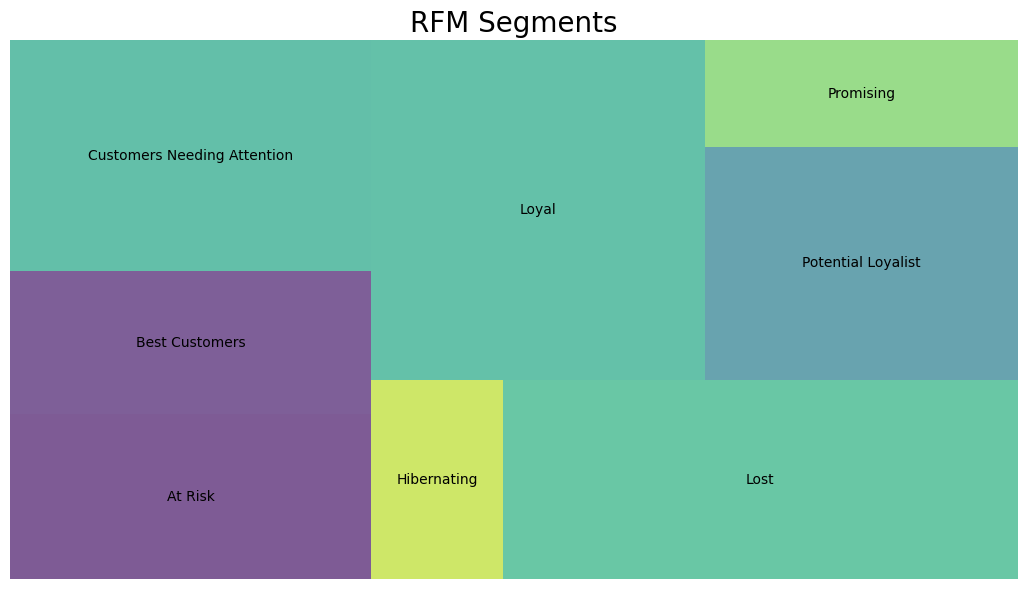

In [14]:
#RFM visualization
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=rfm_agg['customerid'],
              label=['At Risk',
                     'Best Customers',
                     'Customers Needing Attention',
                     'Hibernating',
                     'Lost',
                     'Loyal',
                     'Potential Loyalist',
                     'Promising'], alpha=0.7)
plt.title("RFM Segments",fontsize=20)
plt.axis('off')
plt.show()


                             customerid  percentage
rfm_level                                          
At Risk                             475   10.949746
Best Customers                      414    9.543568
Customers Needing Attention         665   15.329645
Hibernating                         211    4.863993
Lost                                819   18.879668
Loyal                               907   20.908253
Potential Loyalist                  581   13.393269
Promising                           266    6.131858


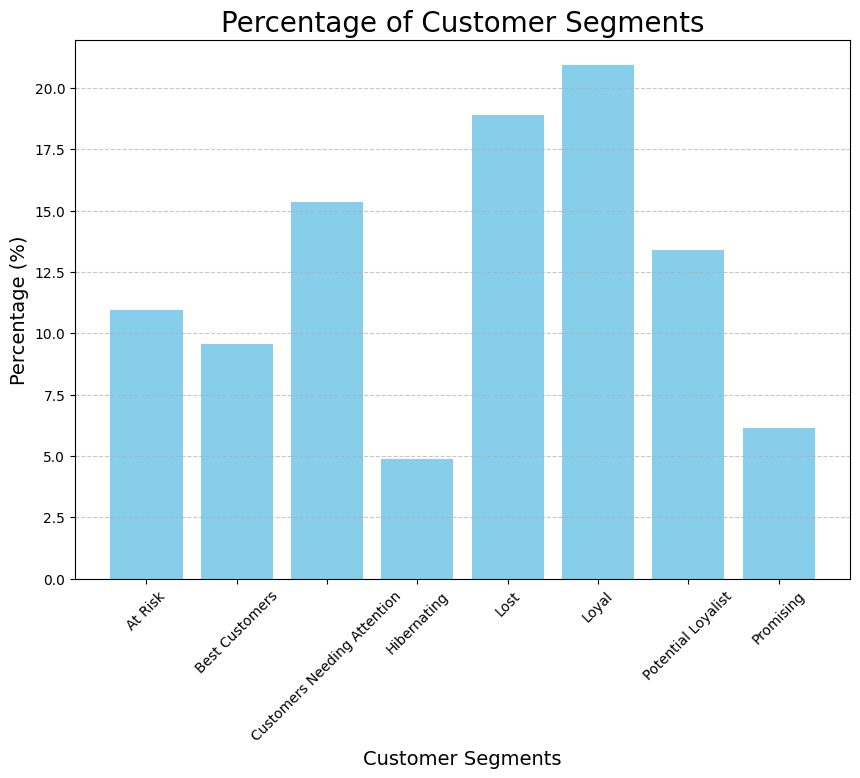

In [15]:
# Calculate total customers
total_customers = rfm_agg['customerid'].sum()

# Calculate the percentage for each segment
rfm_agg['percentage'] = (rfm_agg['customerid'] / total_customers) * 100

# Print the aggregated DataFrame with percentages
print(rfm_agg)

# Plotting the percentages
plt.figure(figsize=(10, 7))
plt.bar(rfm_agg.index, rfm_agg['percentage'], color='skyblue')
plt.title('Percentage of Customer Segments', fontsize=20)
plt.xlabel('Customer Segments', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
# plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


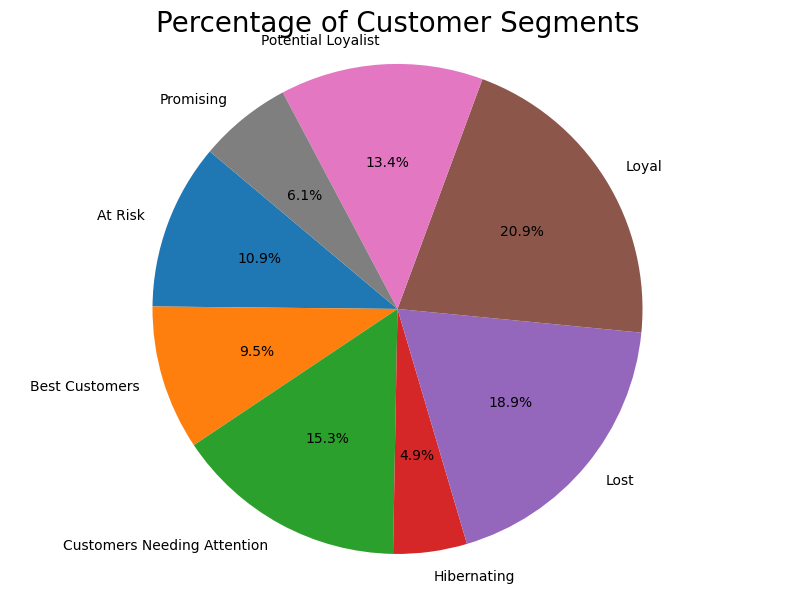

In [16]:
# Plotting the percentages as a pie chart
plt.figure(figsize=(10, 7))
plt.pie(rfm_agg['percentage'], labels=rfm_agg.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Customer Segments', fontsize=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
